In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):

    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)

    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))

    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min

    return pred_list[offset:]

In [ ]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

np.warnings.filterwarnings('ignore')

%matplotlib inline
df = pd.read_csv('/content/drive/MyDrive/NFLX.csv')

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
del df['adj_close']

df.head(10)

,date,open,high,low,close,volume,month
0,2019-04-26,368.350006,375.140015,366.239990,374.850006,5621900,4
1,2019-04-29,373.679993,374.579987,369.119995,371.829987,3821700,4
2,2019-04-30,369.559998,374.500000,368.350006,370.540009,3870100,4
3,2019-05-01,374.000000,385.989990,373.170013,378.809998,9257300,5
4,2019-05-02,378.000000,383.500000,374.510010,379.059998,5398200,5
5,2019-05-03,381.529999,385.029999,378.269989,385.029999,5130300,5
6,2019-05-06,377.690002,381.350006,376.000000,378.670013,5793100,5
7,2019-05-07,377.000000,379.910004,365.809998,370.459991,6974900,5
8,2019-05-08,367.920013,369.000000,361.359985,364.369995,6572000,5
9,2019-05-09,360.899994,364.200012,352.750000,362.750000,5882600,5


Text(0, 0.5, 'USD')

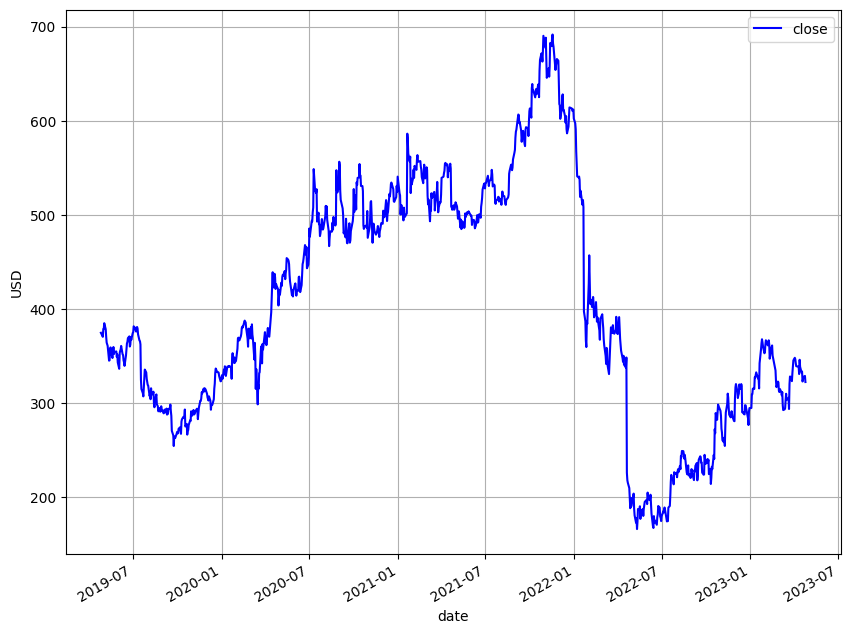

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21
ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 605
num_cv = 201
num_test = 201
train.shape = (605, 7)
cv.shape = (201, 7)
train_cv.shape = (806, 7)
test.shape = (201, 7)


Text(0, 0.5, 'USD')

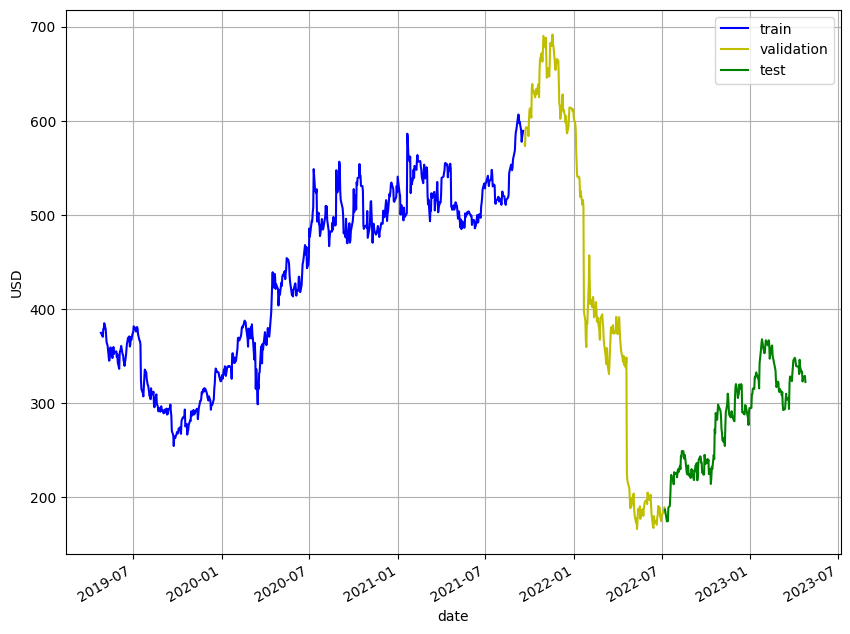

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'close', N, 0, num_train)

    cv.loc[:, 'N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    mape.append(mean_absolute_percentage_error(cv['close'], est_list))

(0.0, 30.0)

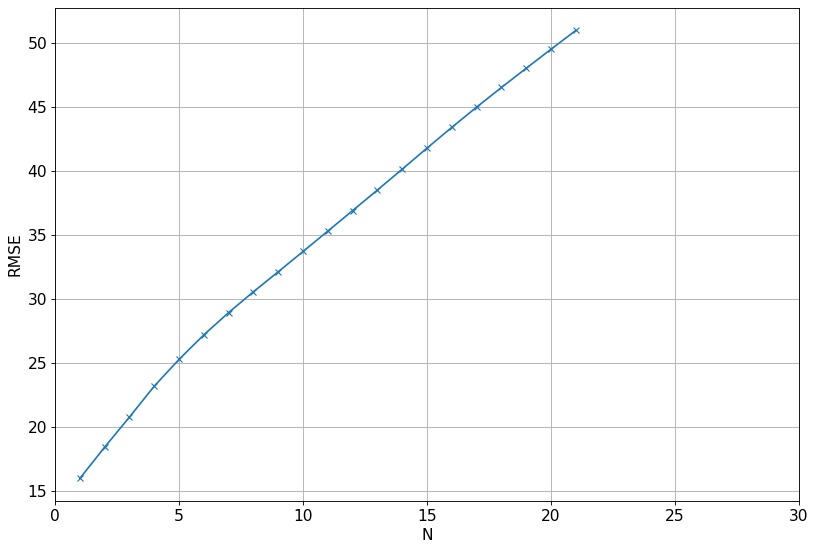

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([0, 30])

Text(0, 0.5, 'USD')

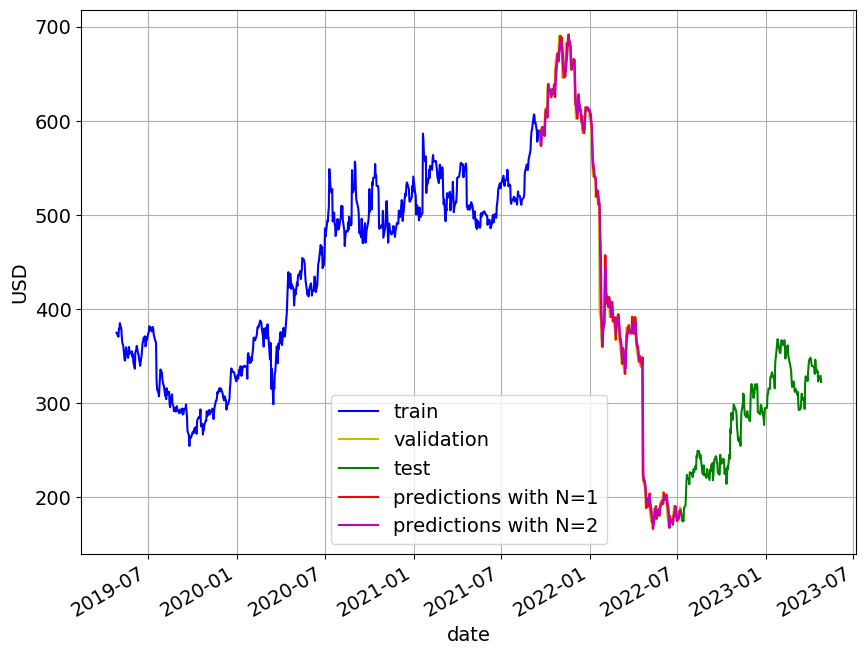

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to cv set')

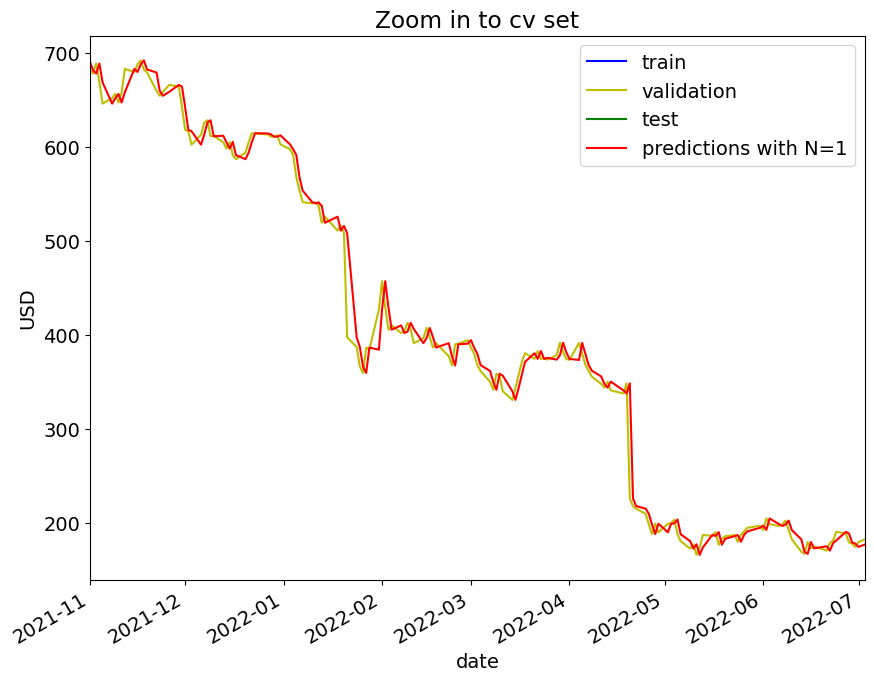

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-')
ax = cv.plot(x='date', y='close', style='y-',  ax=ax)
ax = test.plot(x='date', y='close', style='g-', ax=ax)
ax = cv.plot(x='date', y='N1', style='r-', ax=ax)



ax.legend(['train','validation', 'test','predictions with N=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 11, 1), date(2022, 7, 3)])

ax.set_title('Zoom in to cv set')

In [ ]:
N_opt=1
est_list = get_preds_mov_avg(df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("MAPE = %0.3f" % mean_absolute_percentage_error(test['close'], est_list))

RMSE = 8.492
MAPE = 0.023


(19177.0, 19473.0)

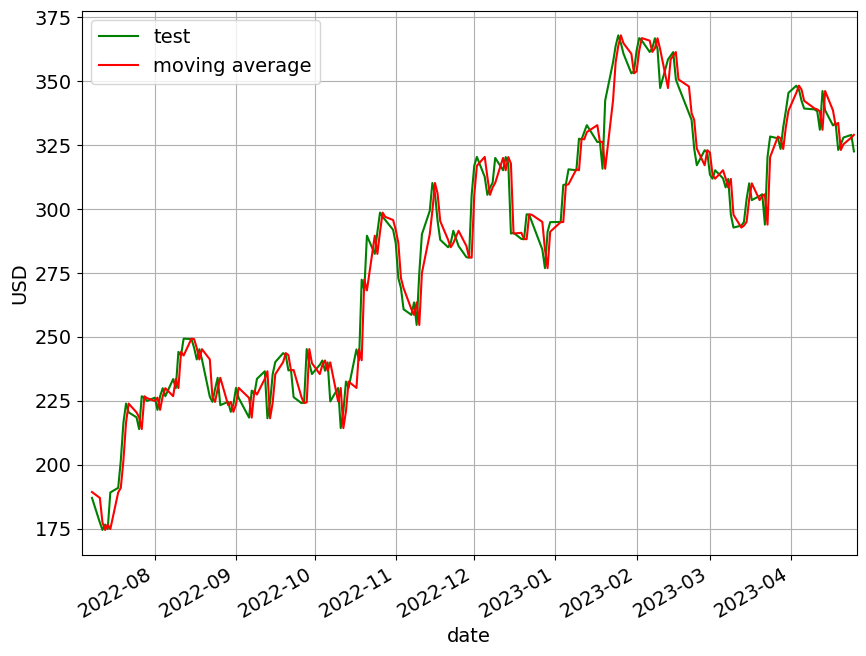

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='close', style='g-', grid=True)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['test', 'moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2022, 7, 4), date(2023, 4, 26)])


Linear Reg

In [ ]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['close'])):
        X_train = np.array(range(len(df['close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train =
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))

        pred_list.append(pred[0][0])  # Predict the footfall using the model

    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min

    return pred_list


In [ ]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'close', N, 0, num_train)

    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['close'])))
    R2.append(r2_score(cv['close'], est_list))
    mape.append(mean_absolute_percentage_error(cv['close'], est_list))

(2.0, 30.0)

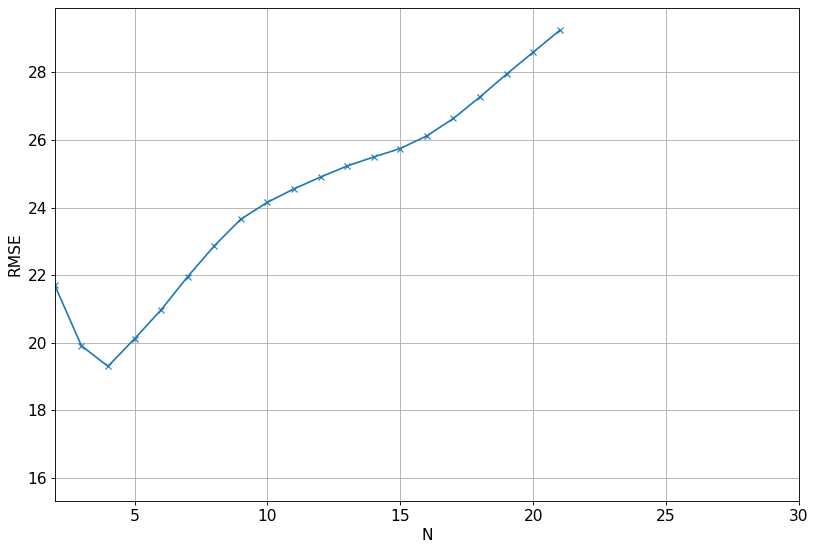

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Text(0, 0.5, 'R2')

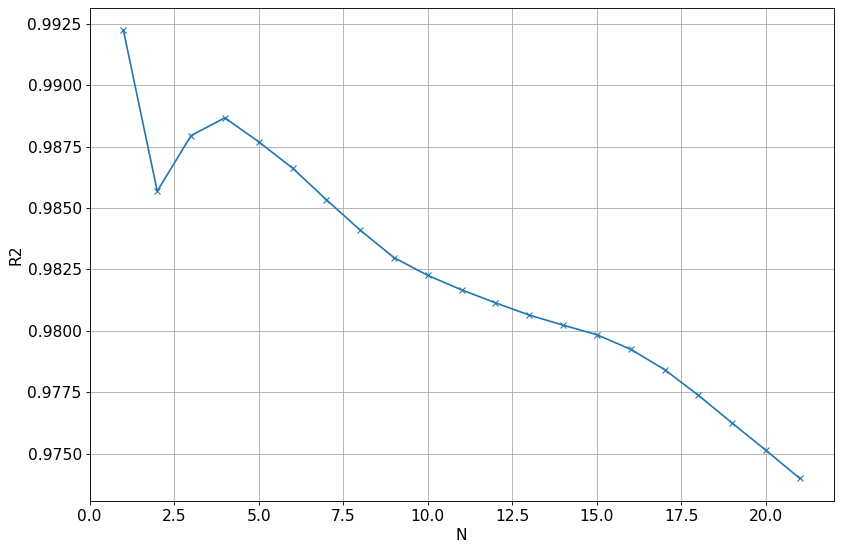

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'USD')

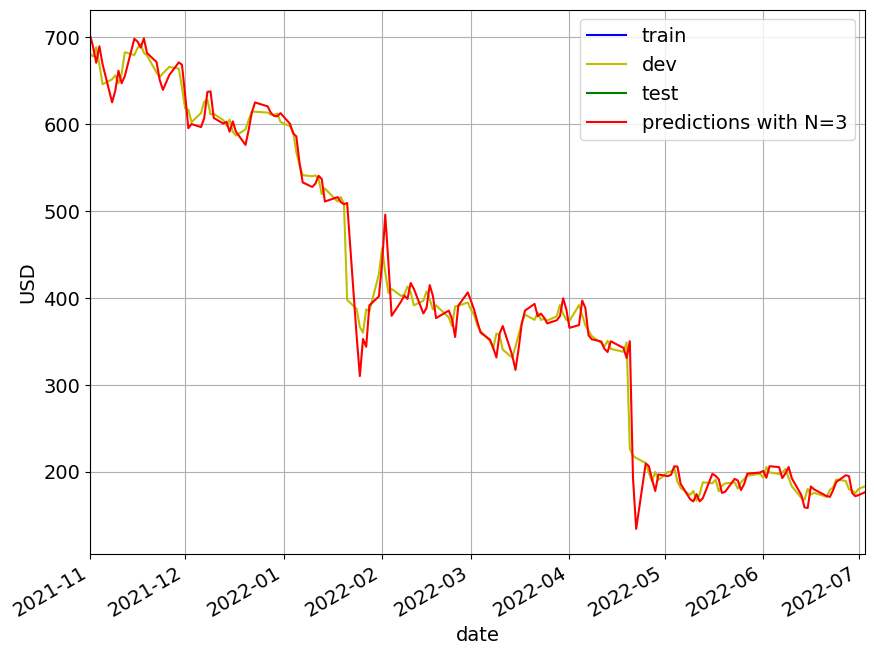

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N3', style='r-', grid=True, ax=ax)
ax.set_xlim([date(2021, 11, 1), date(2022, 7, 3)])
ax.legend(['train', 'dev', 'test', 'predictions with N=3'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
N_opt=3
est_list = get_preds_lin_reg(df, 'close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['close'])))
print("R2 = %0.3f" % r2_score(test['close'], est_list))
print("MAPE = %0.3f" % mean_absolute_percentage_error(test['close'], est_list))

RMSE = 10.096
R2 = 0.959
MAPE = 0.029


Text(0.5, 1.0, 'Zoom in to test set')

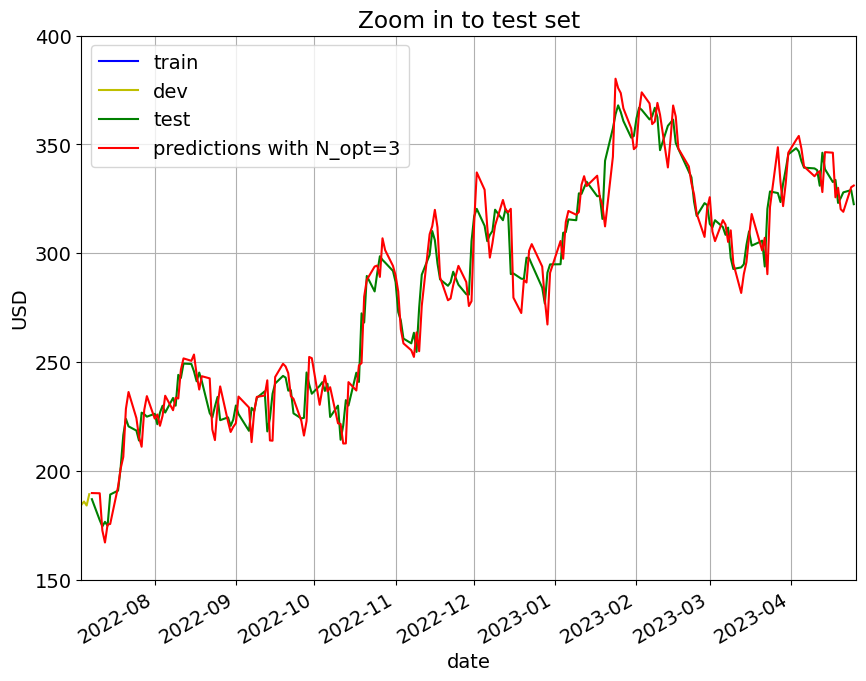

In [ ]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N3', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=3'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2022, 7, 4), date(2023, 4, 26)])
ax.set_ylim([150, 400])
ax.set_title('Zoom in to test set')

**XGBoost**

In [ ]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100


In [ ]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days),
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row-feat_mean) / feat_std

    return row_scaled
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = mean_absolute_percentage_error(y_test, est)

    return rmse, mape, est

In [ ]:
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open'], axis=1, inplace=True)

df.head()

,date,close,volume,month,range_hl,range_oc
0,2019-04-26,374.850006,5621900,4,8.900025,-6.500000
1,2019-04-29,371.829987,3821700,4,5.459992,1.850006
2,2019-04-30,370.540009,3870100,4,6.149994,-0.980011
3,2019-05-01,378.809998,9257300,5,12.819977,-4.809998
4,2019-05-02,379.059998,5398200,5,8.989990,-1.059998


In [ ]:
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['close', 'range_hl', 'range_oc', 'volume']
lag_cols

['close', 'range_hl', 'range_oc', 'volume']

In [ ]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
cols_list = [
"close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,close,volume,month,range_hl,range_oc,order_day,close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,close_mean,close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2019-05-01,378.809998,9257300,5,12.819977,-4.809998,3,370.540009,6.149994,-0.980011,...,-6.500000,5621900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-05-02,379.059998,5398200,5,8.989990,-1.059998,4,378.809998,12.819977,-4.809998,...,1.850006,3821700.0,378.809998,NaN,12.819977,NaN,-4.809998,NaN,9.257300e+06,NaN
5,2019-05-03,385.029999,5130300,5,6.760010,-3.500000,5,379.059998,8.989990,-1.059998,...,-0.980011,3870100.0,378.934998,0.176777,10.904983,2.708210,-2.934998,2.651650,7.327750e+06,2.728796e+06
6,2019-05-06,378.670013,5793100,5,5.350006,-0.980011,6,385.029999,6.760010,-3.500000,...,-4.809998,9257300.0,380.966665,3.521170,9.523326,3.064985,-3.123332,1.903164,6.595267e+06,2.309277e+06
7,2019-05-07,370.459991,6974900,5,14.100006,6.540009,7,378.670013,5.350006,-0.980011,...,-1.059998,5398200.0,380.920003,3.564698,7.033335,1.835320,-1.846670,1.432385,5.440533e+06,3.334217e+05


In [ ]:
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 604
num_cv = 200
num_test = 200
train.shape = (604, 27)
cv.shape = (200, 27)
train_cv.shape = (804, 27)
test.shape = (200, 27)


In [ ]:
cols_to_scale = [
"close"
]

for i in range(1,N+1):
    cols_to_scale.append("close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))

train_scaled.shape = (604, 15)


In [ ]:
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

scaler_train_cv.mean_ = [4.33136591e+02 4.33364900e+02 1.33338418e+01 1.00821219e-01
 6.64720211e+06 4.33591965e+02 1.33322871e+01 1.09341127e-01
 6.64407674e+06 4.33829266e+02 1.33366403e+01 9.98386405e-02
 6.64391318e+06]
scaler_train_cv.var_ = [1.49336650e+04 1.48631219e+04 4.83040511e+01 7.73126146e+01
 4.67788353e+13 1.47936726e+04 4.83265889e+01 7.72839864e+01
 4.67886335e+13 1.47204626e+04 4.82727437e+01 7.73369074e+01
 4.67889464e+13]
train_cv_scaled.shape = (804, 13)
train_cv_scaled.shape = (804, 15)


In [ ]:
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

# Now the entire test set is scaled

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
features = []
for i in range(1,N+1):
    features.append("close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (604, 12)
y_train.shape = (604,)
X_cv.shape = (200, 12)
y_cv.shape = (200,)
X_train_cv.shape = (804, 12)
y_train_cv.shape = (804,)
X_sample.shape = (200, 12)
y_sample.shape = (200,)


In [ ]:
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (604, 12)
y_train_scaled.shape = (604,)
X_cv_scaled.shape = (200, 12)
X_train_cv_scaled.shape = (804, 12)
y_train_cv_scaled.shape = (804,)
X_sample_scaled.shape = (200, 12)


In [ ]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['close_std'] + cv['close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = mean_absolute_percentage_error(y_cv, cv['est'])
print("MAPE on dev set = %0.3f" % mape_bef_tuning)

RMSE on dev set = 16.214
MAPE on dev set = 0.028


Text(0.5, 1.0, 'Zoom in to dev set')

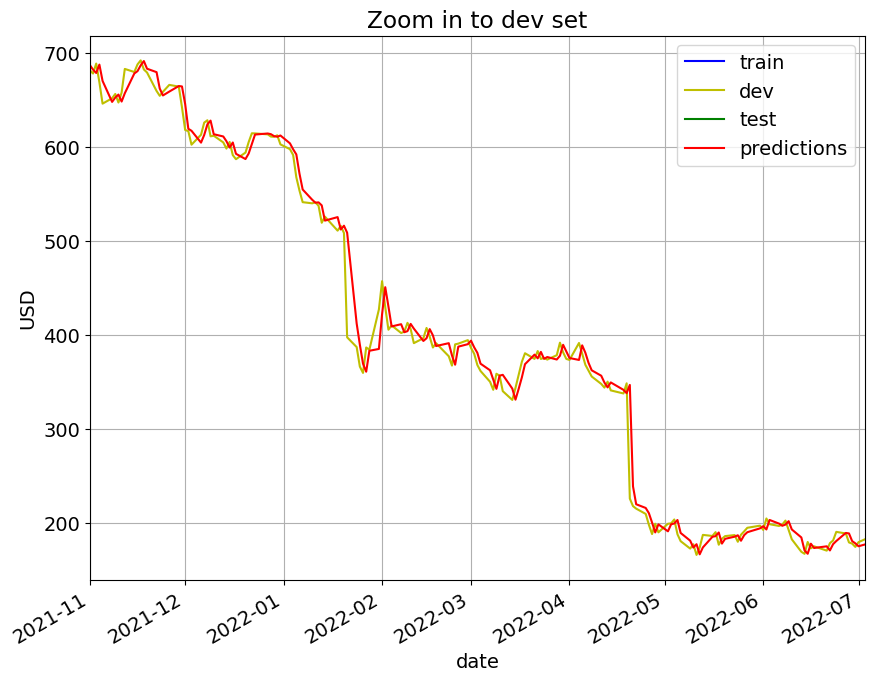

In [ ]:
est_df = pd.DataFrame({'est': cv['est'],
                       'y_cv': y_cv,
                       'date': cv['date']})
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 11, 1), date(2022, 7, 3)])
ax.set_title("Zoom in to dev set")

In [ ]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled,
                             y_train_cv_scaled,
                             X_sample_scaled,
                             y_sample,
                             test['close_mean'],
                             test['close_std'],
                             seed=model_seed,
                             n_estimators=20,
                             max_depth=5,
                             learning_rate=0.1,
                             min_child_weight=13,
                             subsample=1,
                             colsample_bytree=1,
                             colsample_bylevel=1,
                             gamma=0.1)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f" % mape)

RMSE on test set = 8.570
MAPE on test set = 0.023


Text(0.5, 1.0, 'Zoom in to test set')

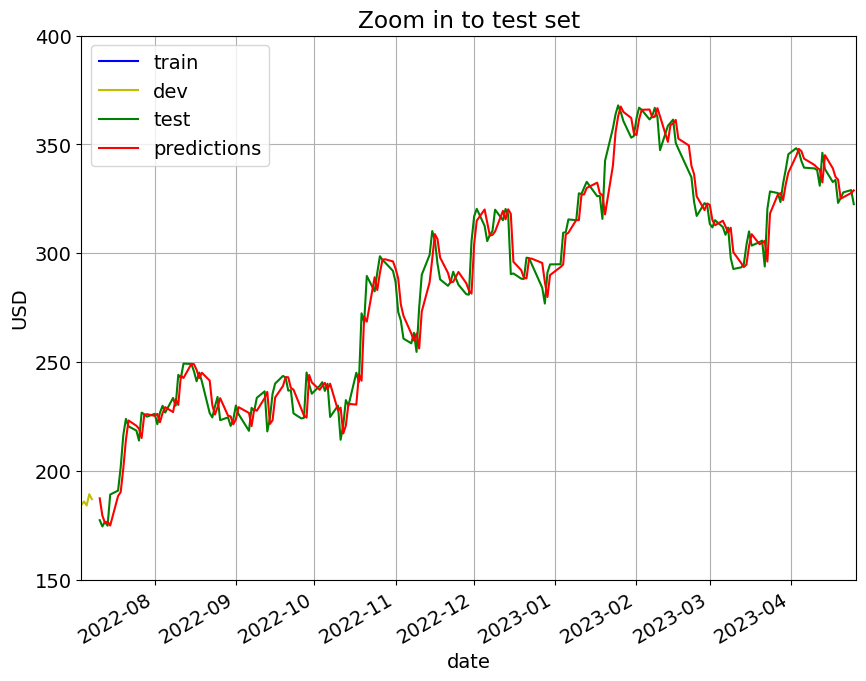

In [ ]:
est_df = pd.DataFrame({'est': est,
                       'y_sample': y_sample,
                       'date': test['date']})
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

ax.set_xlim([date(2022, 7, 4), date(2023, 4, 26)])
ax.set_ylim([150, 400])
ax.set_title("Zoom in to test set")